# Árboles de desición
  
Ésta notebook continua los ejemplos de árboles de desión utilizando datos meteorológicos de la estación meteorológica en Ezeiza. En este caso buscaremos estimar la visibilidad con un modelo de regresión.

`data` es un diccionario que incluye 'dates', 'temperature', 'dewpoint', 'windspeed', 'winddir', 'vis', 'rh', 'pressure', 'undef' (`data.keys()`). 

In [177]:
import SynopDataModule as SDM # para la lectura de los datos
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path


from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split
from sklearn.tree import export_graphviz
from graphviz import Source

# para guardar figuras de los arboles 
IMAGES_PATH = Path() / "images" / "decision_trees"
IMAGES_PATH.mkdir(parents=True, exist_ok=True)

# Lectura de los datos
data = SDM.read_raw_data("../Datos/EXP_133453_HORA.txt")

## Regresión

Para arrancar usamos un solo predictor:

* humedad relativa -- valores cercanos a 100% de humedad deberían estar asociados a niebla 

Pero en este caso, intentaremos estimar el valor de visibilidad (`vis`). 

Cómo antes dividimos los datos en `train` y `test. 

El codigo de dato faltante es: -9999.99


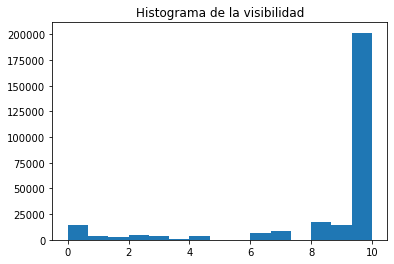

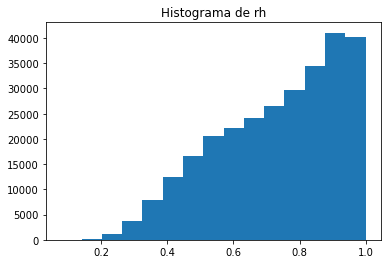

In [178]:
predictores = ["rh"]

# los datos deben estar en arrays
x_values = np.array([data[x] for x in predictores], dtype=object).transpose()
y_values = data["vis"]

#Removemos los datos faltantes 
missing_data = data['undef']
print('El codigo de dato faltante es:',missing_data)
#Generamos una mascara que es True para los valores en los que algun predictor es faltante 
#o bien el target es faltante. 
missing_data_mask = np.any( x_values == missing_data , axis = 1 )
missing_data_mask[ y_values == missing_data ] = True


x_values = x_values[ ~missing_data_mask ]
y_values = y_values[ ~missing_data_mask ]

#Ubicamos la visibilidad maxima en 10 km 
y_values[ y_values > 10.0 ] = 10.0

# separamos los datos en entrenamiento (train) y testeo (testeo)
x_train, x_test, y_train, y_test = train_test_split(x_values, y_values,
                                                    test_size = 0.2,
                                                    shuffle=False)

#Graficamos el histograma de la visibilidad
plt.figure()
plt.hist( y_values , bins=15 , range=(np.min( y_values ), np.max( y_values ) ))
plt.title('Histograma de la visibilidad')

#Graficamos el histograma de los predictores
for ii , my_pred in enumerate( predictores ) :
   plt.figure()
   plt.hist( x_values[:,ii] , bins=15 , range=(np.min( x_values[:,ii] ), np.max( x_values[:,ii] ) ))
   plt.title('Histograma de ' + predictores[ii] )


In [179]:
tree_reg = DecisionTreeRegressor(max_depth = 3,splitter='best')
tree_reg.fit(x_train, y_train)

DecisionTreeRegressor(max_depth=3)

El árbol tiene la siguiente pinta. Siendo `value` el valor de visibilidad predicho en cada caso y `squared_error` el error de la estimación. 

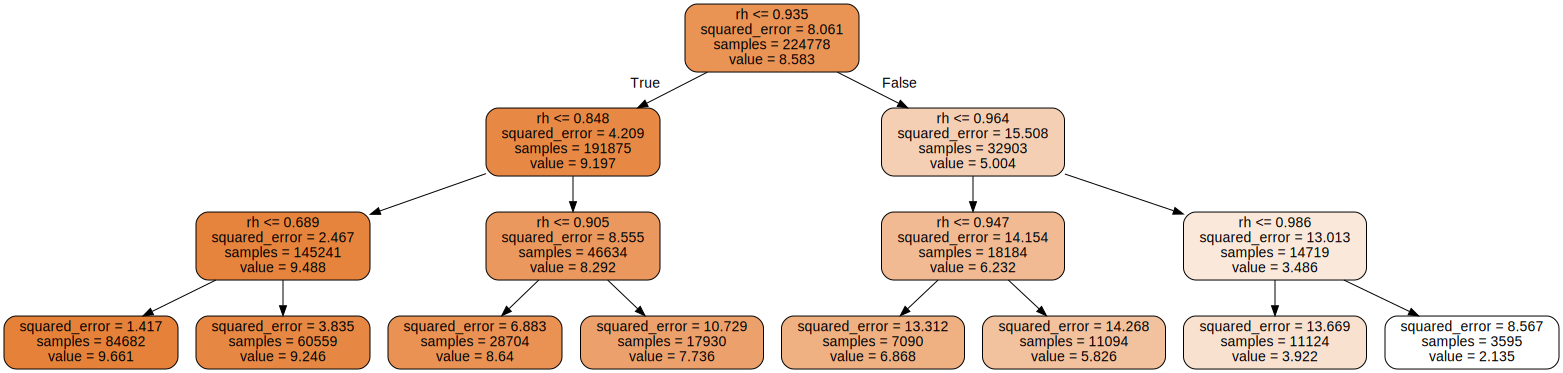

In [180]:
export_graphviz(
    tree_reg,
    out_file = str(IMAGES_PATH / "regression_tree.dot"),
    feature_names = predictores,
    rounded = True,
    filled = True
)
Source.from_file(IMAGES_PATH / "regression_tree.dot")

### Interpretar (5 min): 
    
1. Qué significa la metrica "squared_error" que aparece en cada uno de los nodos y de las hojas?
2. Qué significa el valor "value" que aparece en cada uno de los nodos y de las hojas?
3. Este arbol es consistente con el conocimiento que tenemos de la fisica del problema?

Podemos visualizar los valores predichos (línea negra), que son constantes en los límites de cada umbral de `rh` generado durante el entrenamiento del modelo (líneas rojas en el gráfico). 

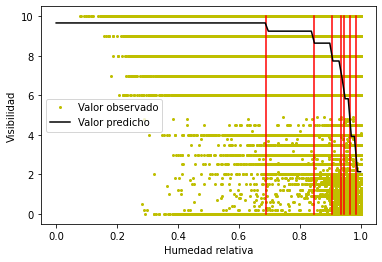

In [181]:
tree_reg = DecisionTreeRegressor(max_depth = 3,splitter='best')
tree_reg.fit(x_train, y_train)

th = tree_reg.tree_.threshold[tree_reg.tree_.threshold != -2.]

x1 = np.linspace(0, 1, 100).reshape(-1, 1)
y_pred = tree_reg.predict(x1)


plt.figure()
plt.plot(x_values, y_values, "yo", markersize = 2, label = "Valor observado")
for t in th:
    plt.plot([t, t], [np.min( y_values ), np.max( y_values )], "r-")
plt.plot(x1, y_pred, "k-", label = "Valor predicho")
plt.xlabel("Humedad relativa")
plt.ylabel("Visibilidad")
plt.legend()

### Para pensar:

1. Por qué el espaciamiento entre las lineas rojas es menor para valores altos de humedad relativa?
2. Qué nos dice esto respecto de la flexibilidad de los arboles de decision como modelos de regresion?

# Testing

Al igual que hicimos con el problema de la clasificacion, podemos evaluar el modelo que obtuvimos para el problema de regresion de diferentes maneras. 
Podemos empezar comparando la prediccion del modelo (output) con el valor esperado (target) para los datos en el conjunto de testing. Idealmente, la relacion entre el output y el target deberia ser lineal con pendiente 1. 

<div>
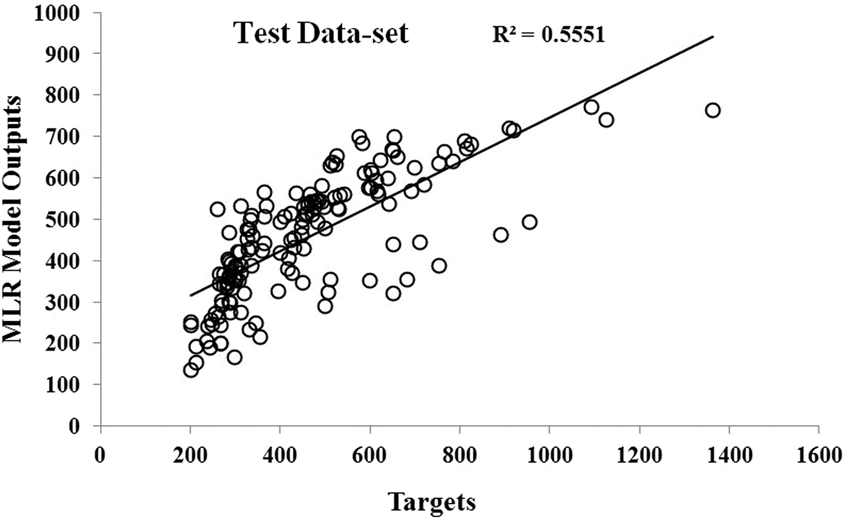
</div>


Veamos como nos va con nuestro arbol!! ... 


Text(0.5, 1.0, 'Logaritmo de la frecuencia relativa de los pares modelo/target')

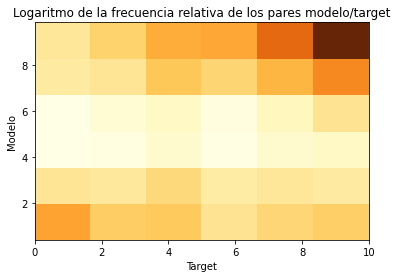

In [182]:
tree_reg = DecisionTreeRegressor(max_depth = 6,splitter='best')
tree_reg.fit(x_train, y_train)
y_pred = tree_reg.predict( x_test )

plt.figure()
#plt.plot( y_pred , y_test , 'o')
h,xedges,yedges,_=plt.hist2d( y_test , y_pred , bins=6, density=False, weights=None, cmin=None, cmax=None)
plt.pcolor(xedges,yedges,np.log(h),cmap='YlOrBr')
plt.xlabel('Target')
plt.ylabel('Modelo')
plt.title('Logaritmo de la frecuencia relativa de los pares modelo/target')


A partir de los pares ordendos $y_{pred}$ , $y_{test}$, podemos calcular diferentes metricas. Por ejemplo:

$$RMSE = \frac{1}{n}\sum_{i=1}^{n}(y_{pred,i}-y_{test,i})^2$$

que es el error cuadratico medio y penaliza las diferencias entre el valor predicho por el modelo y el valor observado. 

$$r = \frac{c(y_{pred},y_{test})}{\sigma_{pred}\sigma_{test}}$$

donde $c(y_{pred},y_{test})$ es la covarianza entre los valores pronosticados y observados y $\sigma_{pred}\sigma_{test}$ son las respectivas desviaciones estandar. 

$$bias = \overline{y_{pred}} - \overline{y_{test}}$$

donde $\overline{y_{pred}}$, $\overline{y_{test}}$ son los valores medios pronosticados por el modelo y observados respectivamente. Este indice nos dice si hay una sobreestimacion o subestimacion sistematica por parte del modelo. 


In [183]:
#Vamos a definir una funcion simple que calcule estos indices.
def compute_scores_reg( y_pred , y_true ) :
    rmse = np.mean( ( y_pred - y_true )**2 )
    rcof = np.corrcoef( y_pred , y_true )[0,1]
    bias = np.mean( y_pred - y_true )
    
    print('El RMSE del modelo es: ',rmse )
    print('El rcof del modelo es: ',rcof )
    print('El bias del modelo es: ',bias )
    
    return rmse , rcof , bias

tree_reg = DecisionTreeRegressor(max_depth = 6,splitter='best')
tree_reg.fit(x_train, y_train)
y_pred = tree_reg.predict( x_test )

rmse , rcof , bias = compute_scores_reg( y_pred , y_test )


El RMSE del modelo es:  4.384736502038412
El rcof del modelo es:  0.6387443269250573
El bias del modelo es:  -0.510221736442964


Interpretar el valor de los diferentes indices!! Que informacion aporta cada uno?

Para investigar: el RMSE se puede descomponer en una componente asociada al bias, al coeficiente de correlacion lineal y a la diferencia en la varianza entre el modelo y las observaciones (ej https://www.7thverificationworkshop.de/Presentation/META_4_Yang.pdf )

### Para analizar (5 min): 
    
1. Cómo se comportan los indices de verificacion cuando variamos la profundidad del arbol?
2. Podemos detectar cuando el modelo esta haciendo "underfitting" u "overfitting" de los datos en base a estos indices?
3. Cúal seria el valor optimo de la profundidad teniendo en cuenta la pregunta anterior?
4. Te animas a graficar el valor de los indices como funcion de la profundidad del arbol?
    

## Ensemble learning

Los arboles de decision son sensibles al "overfitting". De hecho si incrementamos la profundidad del modelo, seguro en algun momento haremos un "overfitting" de los datos. Esto puede resolverse de diferentes maneras las cuales se conocen como metodos de "pruning" o podado del arbol:

* Determinando los parametros óptimos para el entrenamiento (como hicimos en el ejemplo anterior). 

* Utilizando un método objetivo de pruning (que comienza con el entrenamiento de un arbol muy profundo y que va eliminando aquellas ramas que no contribuyan a la mejora en la performance del modelo). 

* Utilizando los métodos de ensambles, que nos permiten entrenar muchos árboles. El ensamble o conjunto de arboles puede ser muy profundo, y cada uno de ellos puede hacer "overfitting" individualmente, pero la media de los arboles permite filtrar aquellas parte de la predicción dominada por el ruido reteniendo la señal. 

Vamos a ver como utilizar él último de los métodos que ha cobrado gran notoriedad recientemente debido a los buenos resultados obtenidos en diferentes problemas tanto de regresión como de clasificación. 

En particular vamos a utilizar una implementación posible que se denomina random forest. Esta técnica introduce cambios aleatorios en el conjunto de datos de entrenamiento y también en la cantidad de predictores que se usan para determinar cada uno de los nodos de un arbol de decisión. Para aplicar random forest para calcular una regresión usamos `RandomForestRegressor` (hay un equivalente para clasificación). 

En este caso `n_estimators` el la cantidad de árboles en el bosque, y `n_jobs = -1` significa que usaremos todos los procesadores disponibles. Aún así es posible que demore. 

In [198]:
from sklearn.ensemble import RandomForestRegressor

NTrees = 500 #Cantidad de arboles en el bosque
#Usamos arboles con mucha profundidad, ya que el ensamble es lo que contribuye a reducir el overfitting.
#raondom_state determina la semilla del generador de numeros pseudo-aleatorios. Random forest es un algoritmo
#estocastico, eso significa que dos realizaciones del algoritmo no necesariamente dan los mismos resultados.
#Al fijar la semilla garantizamos que dos realizaciones del experimento van a dar exactamente igual (por que?)
rf_reg = RandomForestRegressor(n_estimators = NTrees  , max_depth=6 ,
                                n_jobs = -1, random_state = 42 , bootstrap = True )
rf_reg.fit(x_train, y_train)


RandomForestRegressor(max_depth=6, n_estimators=500, n_jobs=-1, random_state=42)


<div>
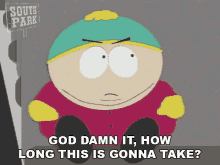
</div>

Por que tarda tanto el entrenamiento del bosque?

Podemos anticipar cuanto mas tardara el entrenamiento del bosque respecto del entrenamiento de un arbol de decisión? 

Y si usamos paralelizacion para entrenar el bosque? Como afecta eso al tiempo de entrenamiento?

... una vez que tenemos nuestro bosque podemos calcular los inidices de verificacion!

In [199]:
y_pred = rf_reg.predict( x_test )
rmse , rcof , bias = compute_scores_reg( y_pred , y_test )

El RMSE del modelo es:  4.3644311676751695
El rcof del modelo es:  0.6398045287521077
El bias del modelo es:  -0.5080520266677047


 Podemos visualizar la curva de regresion para el caso del random forest.
 
 En que difiere respecto de la curva que obtuvimos para los arboles?

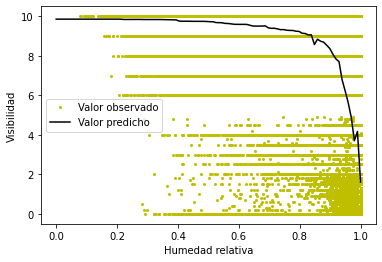

In [200]:

x1 = np.linspace(0, 1, 100).reshape(-1, 1)
y_pred = rf_reg.predict(x1)


plt.figure()
plt.plot(x_values, y_values, "yo", markersize = 2, label = "Valor observado")
plt.plot(x1, y_pred, "k-", label = "Valor predicho")
plt.xlabel("Humedad relativa")
plt.ylabel("Visibilidad")
plt.legend()

Los bosques nos permiten realizar predicciones probabilisticas, ya que, dado un mismo input, cada arbol que compone el bosque predice un valor diferente. Podemos por ejemplo ver cuales son los valores pronosticados por los diferentes arboles para un input determinado y graficar un histograma a partir de eso.

Text(0.5, 1.0, 'Histograma de la visibilidad predicha por el bosque')

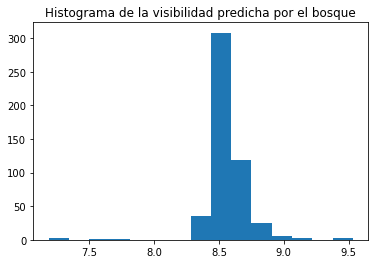

In [187]:
#To the best of our knowledge sklearn no provee una funcion simple para hacer esto. 
#Hay que iterar sobre los arboles que componen el bosque y extraer la prediccion de cada uno. 

Item = 1000  #Elegimos un item cualquiera de la muestra de test para ver las predicciones del bosque.
NTrees = len( rf_reg.estimators_ )
forest_pred = np.zeros( NTrees )  #Vamos a almacenar la prediccion de cada arbol en este array.
for ii , tree in enumerate( rf_reg.estimators_ ) :
   forest_pred[ii] = tree.predict( x_test[Item,:].reshape(-1,1) )[0] 

#Graficamos el histograma de la visibilidad pronosticada por los arboles que componen el bosque
plt.figure()
plt.hist( forest_pred , bins=15 , range=(np.min( forest_pred ), np.max( forest_pred ) ))
plt.title('Histograma de la visibilidad predicha por el bosque')


Podemos evaluar las predicciones probabilisticas como hicimos con el problema de clasificacion. Para eso primero elijamos un umbral y calculemos la probabilidad de que la prediccion este por encima de ese umbral. 



# Agregando predictores



Ahora que tenemos una idea de cómo funciona un árbol de regresión podemos agregar otros predictores:

* la velocidad del viento
* la temperatura

El codigo de dato faltante es: -9999.99


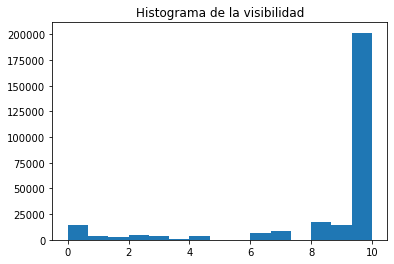

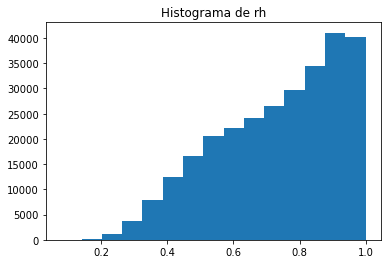

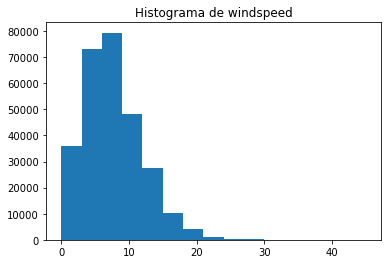

In [74]:
predictores = ["rh", "windspeed" ]
# extraemos la hora del día de `dates`
data["hours"] = np.array([x.hour for x in data["dates"]])
# los datos deben estar en arrays
x_values = np.array([data[x] for x in predictores], dtype=object).transpose()
y_values = data["vis"]

# los datos deben estar en arrays
x_values = np.array([data[x] for x in predictores], dtype=object).transpose()
y_values = data["vis"]

#Removemos los datos faltantes 
missing_data = data['undef']
print('El codigo de dato faltante es:',missing_data)
#Generamos una mascara que es True para los valores en los que algun predictor es faltante 
#o bien el target es faltante. 
missing_data_mask = np.any( x_values == missing_data , axis = 1 )
missing_data_mask[ y_values == missing_data ] = True


x_values = x_values[ ~missing_data_mask ]
y_values = y_values[ ~missing_data_mask ]

#Ubicamos la visibilidad maxima en 10 km 
y_values[ y_values > 10.0 ] = 10.0



# separamos los datos en entrenamiento (train) y testeo (testeo)
x_train, x_test, y_train, y_test = train_test_split(x_values, y_values,
                                                    test_size = 0.2,
                                                    shuffle=False)

#Graficamos el histograma de la visibilidad
plt.figure()
plt.hist( y_values , bins=15 , range=(np.min( y_values ), np.max( y_values ) ))
plt.title('Histograma de la visibilidad')

#Graficamos el histograma de los predictores
for ii , my_pred in enumerate( predictores ) :
   plt.figure()
   plt.hist( x_values[:,ii] , bins=15 , range=(np.min( x_values[:,ii] ), np.max( x_values[:,ii] ) ))
   plt.title('Histograma de ' + predictores[ii] )

Let's train it with our new x_train!!!

<div>
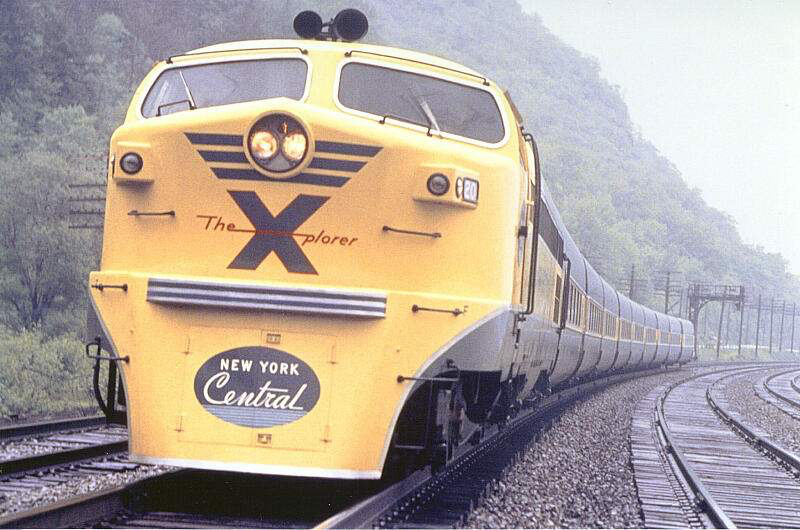
</div>



In [88]:
#Vamos a definir una funcion simple que calcule estos indices.
def compute_scores_reg( y_pred , y_true ) :
    rmse = np.mean( ( y_pred - y_true )**2 )
    rcof = np.corrcoef( y_pred , y_true )[0,1]
    bias = np.mean( y_pred - y_true )
    
    print('El RMSE del modelo es: ',rmse )
    print('El rcof del modelo es: ',rcof )
    print('El bias del modelo es: ',bias )
    
    return rmse , rcof , bias

tree_reg = DecisionTreeRegressor(max_depth = 6,splitter='best' )
tree_reg.fit(x_train, y_train)
y_pred = tree_reg.predict( x_test )

rmse , rcof , bias = compute_scores_reg( y_pred , y_test )


El RMSE del modelo es:  4.384736502038412
El rcof del modelo es:  0.6387443269250573
El bias del modelo es:  -0.510221736442964


## Elección de hiperparámetros

Antes definimos la profundidad del arbol de manera arbitraria y la fuimos modificando manualmente para intentar obtener su valor optimo. 

Podemos evaluar la performance del modelo utilizando distintas combinaciones de hiperparámetros. Para eso aprovechamos `GridSearchCV` que utiliza cross validation para definir que parámetros dan el mejor modelo. 
https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html

En este caso usaremos `max_leaf_nodes`, `max_depth` y `min_samples_split`. Cómo estamos entrenando un árbol para cada combinación de estos parámetros, puede demorar.

La funcion `GridSearchCV` usa cross validacion para separar el conjunto de training en dos y usar una parte para entrenar el arbol y otra parte para validar su desempeño. Notar que en este caso el conjunto de testing no interviene para nada. Ese conjunto se usara para determinar la performance del modelo una vez que la optimizacion de los hiper-parametros haya concluido. El metodo de cross validation utilizado se denomina k-folds o de k-iteraciones ( https://es.wikipedia.org/wiki/Validaci%C3%B3n_cruzada ).


In [90]:
from sklearn.model_selection import GridSearchCV

params = {
    'max_leaf_nodes': [2, 10, 20, 30, 40, 50], 
    'max_depth': list(range(1, 10)),
    'min_samples_split': [100, 500 , 1000, 5000]
}

grid_search_cv = GridSearchCV(DecisionTreeRegressor(splitter='best'),
                              params,
                              cv = 3 , n_jobs = -1)

#n_jobs nos permite paralelizar la tarea aprovechando la potencia de N procesadores o bien seteandolo en -1
#todos los procesadores disponibles.

grid_search_cv.fit(x_train, y_train)

GridSearchCV(cv=3, estimator=DecisionTreeRegressor(), n_jobs=-1,
             param_grid={'max_depth': [1, 2, 3, 4, 5, 6, 7, 8, 9],
                         'max_leaf_nodes': [2, 10, 20, 30, 40, 50],
                         'min_samples_split': [100, 500, 1000, 5000]})

`best_estimator_` nos devuelve el modelo que genera la mejor estimación. 

In [91]:
grid_search_cv.best_estimator_

DecisionTreeRegressor(max_depth=6, max_leaf_nodes=30, min_samples_split=1000)

Por defecto `GridSearchCV` entrena el mejor modelo que encontró, por lo que podemos calcular los indices de verificacion. 

In [92]:
grid_search_cv.score(x_test, y_test)
y_pred = grid_search_cv.predict( x_test )
rmse , rcof , bias = compute_scores_reg( y_pred , y_test )


El RMSE del modelo es:  4.373983832761748
El rcof del modelo es:  0.6394286933721832
El bias del modelo es:  -0.5097495658051256


### Para pensar (5 min):

1. Cómo se usa en este caso el conjunto de entrenamiento para determinar los valores optimos de los hiper-parametros? Estaria bien usar los datos que se usan para entrenar el modelo, para determinar el valor de los hiper-parametros optimos?
2. Todas las combinaciones de hiper-parametros tienen sentido? Por ejemplo, tendria sentido indicar una profundidad maxima grande y una cantidad de hojas maxima pequeñSa? 
3. Existen otros hiper-parametros que se puedan optimizar en el caso de los arboles?

## Posibles ejercicios para la presentación final 

1. Evaluar la performance del modelo modificando el tamaño del ensamble (cantidad del árboles en el bosque). 
2. Analizar los resultados si además de generar distintos datasets usando boostrap, se aplica boostrap en la selección de predictores (Random subspaces). 
3. Entrenar un bosque aleatorios en base a la humedad relativa como predictor y comparar la curva de regresion con la obtenida a partir de un arbol. 